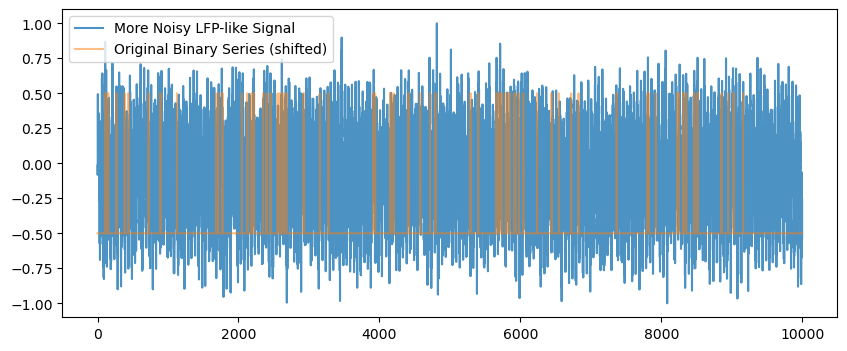

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Generate the original sparse binary series
size = 10_000
prob_1 = 1 / 101
prob_0 = 1 - prob_1
binary_series = np.random.choice([0, 1], size=size, p=[prob_0, prob_1])

# Apply Gaussian smoothing
sigma = 3  # Reduce sigma slightly to retain more noise
smoothed_series = gaussian_filter1d(binary_series.astype(float), sigma=sigma)

# Add high-frequency noise
noise_level = 0.3  # Adjust for more or less noise
high_freq_noise = noise_level * np.random.randn(size)

# Add oscillatory fluctuations (simulating brain wave activity)
freq = 20  # Frequency of oscillations in Hz (adjust as needed)
sampling_rate = 1000  # Simulating 1 kHz sampling rate
time = np.arange(size) / sampling_rate
oscillatory_component = 0.5 * np.sin(2 * np.pi * freq * time)  # Sinusoidal oscillations

# Combine components
noisy_series = smoothed_series + high_freq_noise + oscillatory_component

# Normalize between -1 and 1
noisy_series = 2 * (noisy_series - np.min(noisy_series)) / (np.max(noisy_series) - np.min(noisy_series)) - 1

# Plot results
plt.figure(figsize=(10, 4))
plt.plot(noisy_series, label="More Noisy LFP-like Signal", alpha=0.8)
plt.plot(binary_series - 0.5, label="Original Binary Series (shifted)", alpha=0.5)
plt.legend()
plt.show()


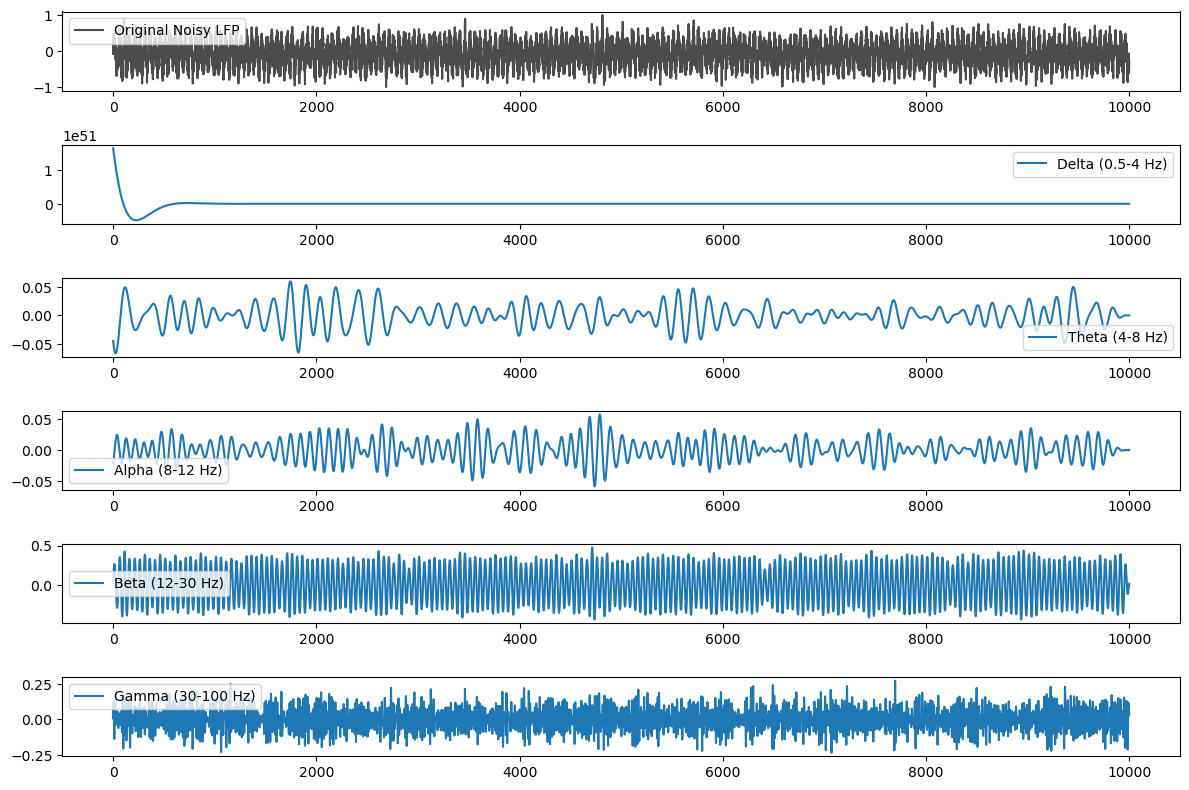

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Function to create a bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Sampling rate (assuming 1 kHz for LFP-like data)
fs = 1000  

# Define frequency bands
bands = {
    "Delta (0.5-4 Hz)": (0.5, 4),
    "Theta (4-8 Hz)": (4, 8),
    "Alpha (8-12 Hz)": (8, 12),
    "Beta (12-30 Hz)": (12, 30),
    "Gamma (30-100 Hz)": (30, 100),
}

# Apply filters for each band
filtered_signals = {name: bandpass_filter(noisy_series, low, high, fs) for name, (low, high) in bands.items()}

# Plot the results
plt.figure(figsize=(12, 8))
plt.subplot(len(bands) + 1, 1, 1)
plt.plot(noisy_series, label="Original Noisy LFP", color="black", alpha=0.7)
plt.legend()

for i, (name, signal) in enumerate(filtered_signals.items(), start=2):
    plt.subplot(len(bands) + 1, 1, i)
    plt.plot(signal, label=name)
    plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


217/217 ━━━━━━━━━━━━━━━━━━━━ 60s 255ms/step - accuracy: 0.9793 - loss: 3.9954 - val_accuracy: 0.9912 - val_loss: 0.2235
Epoch 2/5
217/217 ━━━━━━━━━━━━━━━━━━━━ 67s 308ms/step - accuracy: 0.9921 - loss: 0.1580 - val_accuracy: 0.9912 - val_loss: 0.0759
Epoch 3/5
217/217 ━━━━━━━━━━━━━━━━━━━━ 68s 312ms/step - accuracy: 0.9924 - loss: 0.0705 - val_accuracy: 0.9912 - val_loss: 0.0628
Epoch 4/5
217/217 ━━━━━━━━━━━━━━━━━━━━ 67s 308ms/step - accuracy: 0.9938 - loss: 0.0495 - val_accuracy: 0.9912 - val_loss: 0.0543
Epoch 5/5
217/217 ━━━━━━━━━━━━━━━━━━━━ 72s 332ms/step - accuracy: 0.9923 - loss: 0.0563 - val_accuracy: 0.9912 - val_loss: 0.0529


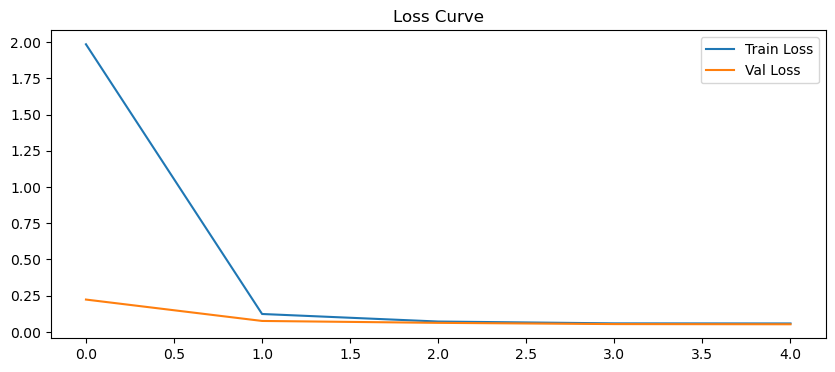

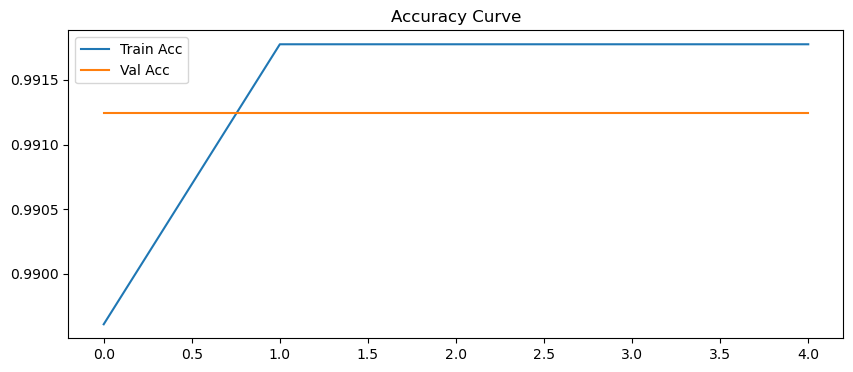

93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9919 - loss: 0.0497
Test Accuracy: 0.9912
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step


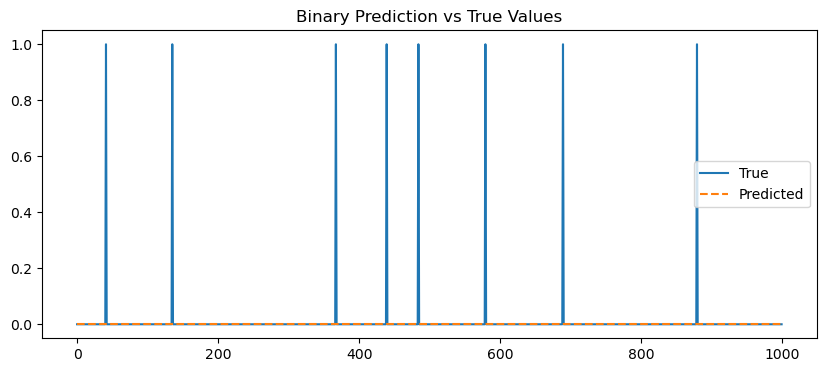

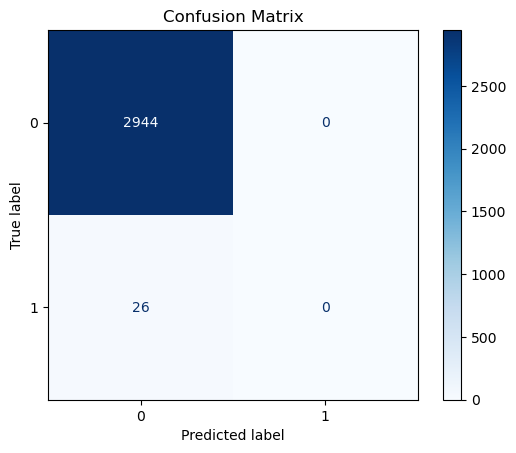

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, LayerNormalization
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Bandpass filter function
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Sampling rate
fs = 1000  

# Frequency bands
bands = {
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 12),
    "Beta": (12, 30),
    "Gamma": (30, 100),
}

# Apply filters to decompose LFP
filtered_signals = np.array([bandpass_filter(noisy_series, low, high, fs) for _, (low, high) in bands.items()]).T  # Shape: (10_000, 5)

# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(filtered_signals)

# Reshape for LSTM (samples, timesteps, features)
sequence_length = 100  # Use 100 time steps per input sample
X = np.array([X_scaled[i:i+sequence_length] for i in range(len(X_scaled) - sequence_length)])
y = binary_series[sequence_length:]  # Align with sequence windows

# Train/test split (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

# Define BiLSTM model
model = Sequential([
    Bidirectional(
        LSTM(128, return_sequences=True, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)), 
        input_shape=(X_train.shape[1], X_train.shape[2])
    ),
    LayerNormalization(),
    Dropout(0.2),

    Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.2, kernel_regularizer=l2(0.01))),
    LayerNormalization(),
    Dropout(0.2),

    Bidirectional(LSTM(32, return_sequences=False, recurrent_dropout=0.2, kernel_regularizer=l2(0.01))),
    LayerNormalization(),
    Dropout(0.2),

    Dense(32, activation="relu"),  
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)

# Plot training history
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")

plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy Curve")

plt.show()

# Evaluate performance
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Show some predictions
plt.figure(figsize=(10, 4))
plt.plot(y_test[:1000], label="True")
plt.plot(y_pred[:1000], label="Predicted", linestyle="dashed")
plt.legend()
plt.title("Binary Prediction vs True Values")
plt.show()



# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()
